# Connected Intersections (CI): 
### SRM, SSM and BSM Data Interactions

## 1. Objective & Research Question 
Determine how different connected vehicle messages interact with a connected intersection to produce an assignment based intersection management system?

Ideally, see a vehicle message trail 
1. Vehicle coming into an intersection
2. Requesting signal priority
3. The corresponding response, and resulting BSM trail leaving the intersection.

- Use Cases
    * Exploratory notebook to determine how to relate BSM/SSM/SRM message sets. View BSM and corresponding SSM/SRM messages geospatially.
    * Extending the green light phase to allow transit vehicles to travel freely through intersections
    * Providing an early green light phase to allow transit vehicles to spend less time idling at an intersection
    * Dedicating bypass lanes, also known as high occupancy vehicle (HOV) lanes, or queue jump lanes for buses

Version  |    Date          |  Author                |   Notes                                                                           |
:-------:|:----------------:|:-----------------------|:----------------------------------------------------------------------------------
1.0      |16 October 2022       | Ken Dizon  | Initial version
1.1      |11 November 2022   | Ken Dizon  | Cleaner integration of BigQuery and confiugration of SSM
1.2      |5 December 2022   | Ken Dizon             | Documentation and addition of all SAE standards

## Content 

- **1. Objective**
  * 1.1 Python Settings
  * 1.2 Methodology
  * 1.3 TSP - Traffic Signal Priority
    
- **2. SRM: Signal Request Message**
    * 2.1 Query SRM Database
    * 2.2 SRM Counts
- **3. SRM Data Validation**
    * 3.1 Query SAE Standards for SRM
    * 3.2 SRM Data Wrangling/Cleaning
    * 3.3 SRM Data Visualization
- **4. SSM Signal Status Message**
    * 4.1 Query SAE Standards for SSM
    * 4.2 SSM Data Wrangling/Cleaning
- **5. BSM: Basic Safety Message**
    * 5.1 Query SAE Standards for BSM
    * 5.2 BSM Data Wrangling/Cleaning
- **6. Results**
    * 6.1 Message Data Integration
    * 6.2 TSP Visual Model

In [2]:
# Libraries

# from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import datetime

mapbox_access_token = 'pk.eyJ1IjoiZGl6b25rIiwiYSI6ImNsNno3YmR5czAxbHYzdW5xZ3hiajhkajMifQ.F7xeTKvCttPUQJFs-9Au9A'
px.set_mapbox_access_token(mapbox_access_token)

___________
## 1.2 Connected Intersections Methodology Flow Chart

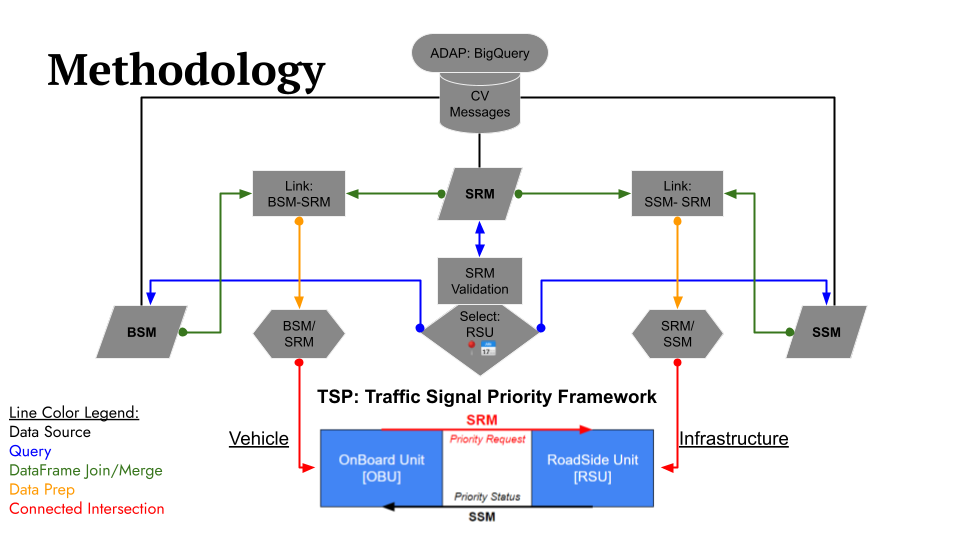

_____________________________
## 1.2 TSP - Traffic Signal Priority

A TSP system is composed of three major components: 
- (1) the vehicle detection system that detects transit vehicles and generates priority requests 
- (2) the traffic signal control system that receives and processes the request for priority at the intersections 
- (3) the communications system that links the vehicle detection system with the traffic signal control system.

## Flow Chart
###### Legend
[Hardware] (message)

    #Vehicle                                          #Infrastructure
     __________________                                ____________________
    |        ➡        | ➡➡      (SRM)         ➡➡  |         ⬇         |
    |      (BSM)       | ➡➡  Priority Request  ➡➡  |       (BSM)       |
    |OnBoard Unit [OBU]                                RoadSide Unit [RSU]|
    |        ⬆         | ⬅⬅  Priority Status   ⬅⬅  |        ⬅         |
    |__________________| ⬅⬅      (SSM)         ⬅⬅  |___________________|       
_____________________________

# 2. SRM: Signal Request Message
### [OBU] ➡ SRM
- Locate valid Signal Request Messages in a RSU. 
- SRM (Signal Request Message) as not all intersections will receive a request.
    - Broadcast by a vehicle (OnBoard Unit) to infrastructure (Roadside Unit) 
    - SRM to RSU
    
## 2.1 Query SRM
- Find Signal Request Messages (SRM) locations

In [3]:
# srm_count = client.query(query_SRM).to_dataframe()

### Saving SQL query to hardrive ###
# srm_count.to_csv('raw_srm_count.csv', index=False)
srm_count = pd.read_csv('raw_srm_count.csv')
srm_count.head()

,RSU,localDate,SRM_count
0,10.11.81.18,2022-10-26,33
1,10.11.81.19,2022-10-26,7
2,10.11.81.13,2022-10-27,143
3,10.11.81.14,2022-10-27,182
4,10.11.81.18,2022-10-27,548


In [5]:
srm_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   RSU        33 non-null     object
 1   localDate  33 non-null     object
 2   SRM_count  33 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 920.0+ bytes


In [9]:
srm_count['localDate'] = pd.to_datetime(srm_count['localDate'])

In [10]:
startDate = srm_count['localDate'].iloc[0]
endDate = srm_count['localDate'].iloc[-1]
dayCount = endDate - startDate

print('Date Range:', startDate, 'to', endDate)
print('Days:', dayCount)

Date Range: 2022-10-26 00:00:00 to 2022-11-08 00:00:00
Days: 13 days 00:00:00


### 2.1. SRM Counts

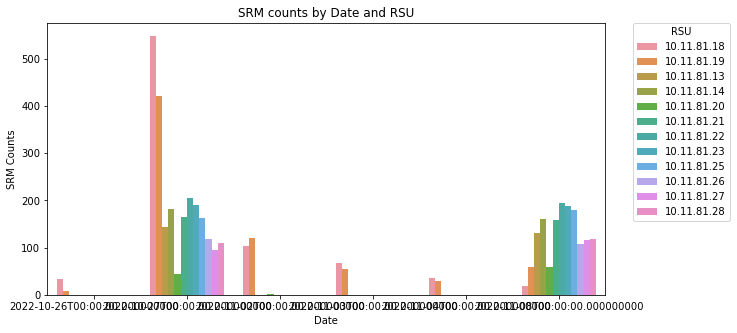

In [11]:
# Visualize SRM Counts
plt.figure(figsize=(10,5))
ax  = sns.barplot(data = srm_count,
                  x = "localDate", y = "SRM_count",
                  hue = "RSU")

plt.legend(title='RSU', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('SRM counts by Date and RSU')
plt.xlabel('Date')
plt.ylabel('SRM Counts')
plt.show()

**Note:** Date October 27th and November 8th have high frequency of SRM Messages. RSU units .18/.19 are constant. 

In [12]:
# Top 5
print('Top 5 Counts:')
srm_count.sort_values(by='SRM_count', ascending=False).head()

Top 5 Counts:


,RSU,localDate,SRM_count
4,10.11.81.18,2022-10-27,548
5,10.11.81.19,2022-10-27,421
8,10.11.81.22,2022-10-27,205
27,10.11.81.22,2022-11-08,194
9,10.11.81.23,2022-10-27,191


**Note** : October 27th (10/27) has the most SRM counts. RSU 10.11.81.22 has 205 counts which is managable. We will use this for our SQL query as follows.

#### 2.2 SQL Query Notes
RSU  |    Date          |  SRM_Count        |
:---:|:----------------:|:-----------------:|
11.11.81.22 | 27 October 2022 | 205 | 

______

## 3. SRM Data Validation

- **SAE Standards for SRM**: connected intersection (CI) Surface Vehicle Standard: https://www.sae.org/standards/content/j2735_202007/
    * Message: MSG_SignalRequestMessage (SRM)
        - **Use:** The signal request message (SRM) is a message sent by a V2X-equipped entity (such as a vehicle) to the RSU in a signalized intersection. It is used for either a priority signal request or a preemption signal request depending on the way  each request is set. Each request defines a path through the intersection which is desired in terms of lanes and approaches to be used. Each request can also contain the time of arrival and the expected duration of the service. Multiple requests to multiple intersections are supported. The requestor identifies itself in various ways (using methods supported by the  RequestorDescription data frame), and its current speed, heading, and location can be placed in this structure as well. The specific request for service is typically based on previously decoding and examining the list of lanes and approaches for that intersection (sent in MAP messages). The outcome of all of the pending requests to a signal can be found in the signal status message (SSM), and may be reflected in the SPAT message contents if successful. 

### 3.1. Query SAE Standards for SRM

- REQUIRED vs OPTIONAL: SAE_J2735_202007

***SignalRequestsMessage: Schema***

SRM DataFrames | DataFrame Name | Representation |  Description |
:-------------:|:--------------:|:-----------:|:--------------:|
srm - metadata | originIP - rsuIP | User Implementation | Roadside Unit Device |
srm -metadata | odeReceivedAt - ode_timeStamp | User Implementation | CDOT Connected Vehilce Operational Data Environment | 
timeStamp | MinuteOfTheYear | OPTIONAL | The Estimated Time of Arrival (ETA) when the service is requested |
second | DSecond | STANDARD |  The Estimated Time of Arrival (ETA) when the service is requested |
sequenceNumber | MsgCount| OPTIONAL | Sequence number within a stream of messages with the same DSRCmsgID and from the same sender | 
requests | SignalRequestList/SignalRequestPackage | OPTIONAL | Request Data for one or more signalized intersections that support SRM dialogs
requestor | RequestorDescription | STANDARD | Requesting Device and other User Data contains vehicle ID (if from a vehicle) as well as type data and current position and may contain additional transit data |


***SignalRequestPackage: DF requests***
- Use: The DF_SignalRequestPackage data frame contains both the service request itself (the preemption and priority details and the inbound-outbound path details for an intersection) and the time period (start and end time) over which this service is sought from one single intersection. One or more of these packages are contained in a list in the signal request message(SRM)

SignalRequestPackage | Feature Name | Representation | Description |
:------:|:------------:|:--------------:|:-----------:|
id - IntersectionReferenceID | region - RoadRegulatorID | OPTIONAL | the unique ID of the target intersection |
id - IntersectionReferenceID | id - IntersectionID | STANDARD | the unique ID of the target intersection |
requestID | RequestID | STANDARD | the unique requestID used by the requestor |
requestType | PriorityRequestType | STANDARD | the type of request or cancel for priority or preempt use when a prior request is canceled, only the requestID is needed |
inBoundLane - IntersectionAccessPoint | LaneID | STANDARD |  desired entry approach or lane |
inboundLane - IntersectionAccessPoint | ApproachID | STANDARD |  desired entry approach or lane |
inboundLane - IntersectionAccessPoint | LaneConnectionID | STANDARD |  desired entry approach or lane |
outBoundLane - IntersectionAccessPoint | | OPTIONAL |  desired exit approach or lane, the values zero is used to indicate intent to stop within the intersection |


***SignalRequestPackage: DF requestor***
- Use: The DF_RequestorDescription data frame is used to provide identity information about a selected vehicle or users. This data frame is typically used with fleet type vehicles which can (or which must) safely release such information for use with probe measurements or with other interactions (such as a signal request).

RequestorDescription | Feature Name | Representation | Description |
:------:|:------------:|:--------------:|:-----------:|
id - VehicleID | entityID - TemporaryID | STANDARD | The ID used in the BSM or CAM of the requestor. This ID is presumed not to change during the exchange |
id - VehicleID | stationID - StationID | STANDARD | The ID used in the BSM or CAM of the requestor. This ID is presumed not to change during the exchange |
type - RequestorType | role - BasicVehicleRole | OPTIONAL |  Information regarding all type and class data about the requesting vehicle |
type - RequestorType | subrole - RequestSubRole | OPTIONAL |  A local list with role based items |
type - RequestorType | request - RequestImportanceLevel | OPTIONAL |  Defines what kind of request (a level of importance in the Priority Scheme) |
type - RequestorType | iso3883 - Iso3833VehicleType | OPTIONAL | Additional classification details |
type - RequestorType | hpmsType - VehicleType | OPTIONAL | Additional classification details |
position - RequestorPositionVector | position - Position3D | OPTIONAL |  The location of the requesting vehicle |
position - RequestorPositionVector | heading - Angle | OPTIONAL |  360 degree directional |
position - RequestorPositionVector | speed - Velocity | OPTIONAL |  Meters per Second |
name | DescriptiveName | OPTIONAL |  A human readable name for debugging use |

________________________
#### SQL Query Notes
RSU  | IntersectionID |    Date          |  SRM_Count        |
:---:|:----------------:|:-----------------:|:-------:|
11.11.81.22 | Bowel Ave #12107 | 27 October 2022 | 205 | 

In [41]:
# Load Data
srm_raw = pd.read_csv('raw_srm_df.csv')
srm_raw.head()

,rsuIP,ode_timeStamp,MinuteOfTheYear,DSecond,MsgCount,IntersectionID,RequestID,PriorityRequestType,LaneID,ApproachID,LaneConnectionID,TemporaryID,StationID,Lat,Lon,Heading,Velocity
0,10.11.81.22,2022-10-27 12:51:38.881199,431691,0,1,12110,7,priorityRequest,9,NaN,NaN,NaN,1780166822,39.590949,-105.091216,356.5,22.30
1,10.11.81.22,2022-10-27 12:51:39.886269,431691,0,2,12110,7,priorityRequest,9,NaN,NaN,NaN,1780166822,39.591150,-105.091230,357.0,22.38
2,10.11.81.22,2022-10-27 12:51:40.875645,431691,0,3,12110,7,priorityRequest,9,NaN,NaN,NaN,1780166822,39.591352,-105.091243,357.1,22.56
3,10.11.81.22,2022-10-27 12:51:41.878175,431691,0,4,12110,7,priorityRequest,9,NaN,NaN,NaN,1780166822,39.591554,-105.091256,357.4,22.58
4,10.11.81.22,2022-10-27 12:51:42.881281,431691,0,5,12110,7,priorityRequest,9,NaN,NaN,NaN,1780166822,39.591758,-105.091267,358.0,22.62


## 3.2 SSM Data Wrangling/Cleaning

In [42]:
srm_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rsuIP                205 non-null    object 
 1   ode_timeStamp        205 non-null    object 
 2   MinuteOfTheYear      205 non-null    int64  
 3   DSecond              205 non-null    int64  
 4   MsgCount             205 non-null    int64  
 5   IntersectionID       205 non-null    int64  
 6   RequestID            205 non-null    int64  
 7   PriorityRequestType  205 non-null    object 
 8   LaneID               205 non-null    int64  
 9   ApproachID           0 non-null      float64
 10  LaneConnectionID     0 non-null      float64
 11  TemporaryID          0 non-null      float64
 12  StationID            205 non-null    int64  
 13  Lat                  205 non-null    float64
 14  Lon                  205 non-null    float64
 15  Heading              205 non-null    flo

In [43]:
srm_raw.columns[srm_raw.isna().any()].tolist()

['ApproachID', 'LaneConnectionID', 'TemporaryID']

**Note** : The SAE standards to [inboundLane - IntersectionAccessPoint] result in index 9, 10 & 11 having null values. This is problamtic due to required standards for a connected intersection application to be functionally complete. 

##### Missing Data

- Request
    * DSecond -- STANDARD [is replaced by ode_timeStamp]
- Request: SignalRequestPackage (OPTIONAL)
    * ApproachID -- STANDARD
    * LaneConnectionID -- STANDARD
    
By not having these two features I am unable to locate the exact desired entry approach or lane of a vehicle

- Requestor: 
    * TemporaryID -- STANDARD  
    
The missing feature of TemporaryID used in the BSM or CAM of the requestor. This ID is presumed not to change during the exchange. Without the TemporaryID, how may we identify the specific vehicle to other message sets (BSM, SRM)?

In [44]:
# Unique values in each column
srm_raw.nunique().sort_values(ascending=True)

TemporaryID              0
LaneConnectionID         0
ApproachID               0
rsuIP                    1
StationID                1
DSecond                  1
PriorityRequestType      2
IntersectionID           6
MinuteOfTheYear          7
LaneID                   9
RequestID               12
Heading                 46
MsgCount                95
Velocity               158
Lon                    199
Lat                    204
ode_timeStamp          205
dtype: int64

Text(0.5, 1.0, 'SRM_Data')

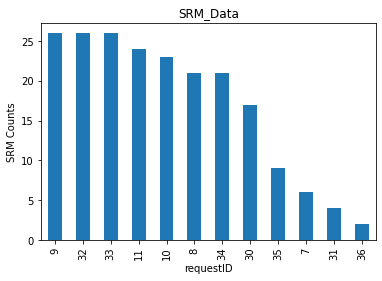

In [45]:
# Plot Data by different requestIDs
_ = srm_raw['RequestID'].value_counts().plot.bar()
plt.xlabel('requestID')
plt.ylabel('SRM Counts')
plt.title('SRM_Data')

In [46]:
# Request ID by timing
srm_fig = px.scatter(srm_raw, x='ode_timeStamp', y='MsgCount', color='RequestID',
                     hover_name='RequestID',  hover_data=['Heading', 'PriorityRequestType', 'LaneID'],
                     title='SRM timing',
                     width=800, height=400)
srm_fig.show()

In [47]:
#Define the bounding box 
Bbox_srm = ((srm_raw.Lon.min(), srm_raw.Lon.max(),      
         srm_raw.Lat.min(), srm_raw.Lat.max()))
Bbox_srm

(-105.0915579, -105.0909261, 39.5909488, 39.6259187)

In [48]:
srm_raw_fig = px.scatter_mapbox(srm_raw, lat="Lat", lon="Lon", zoom=12, color='RequestID',
                            hover_data = ['ode_timeStamp', 'RequestID', 'Heading', 'PriorityRequestType', 'LaneID', 'IntersectionID'],
                            center=dict(lon=Bbox_srm[0], lat=Bbox_srm[3]),
                            width=450*1.5, height=450*1.5,
                            mapbox_style='dark') #'open-street-map')
srm_raw_fig.show()

##### Target Specifc Intersetion

In [49]:
# Select specific intersection ID
srm_raw = srm_raw.loc[srm_raw['IntersectionID'] == 12107]

In [50]:
# SRM Standards - According to SAE J2735

# create subset dataframes
srm_requests = srm_raw.iloc[:,[
    1, 5, 6, 7, 8, 9, 10]]

srm_requestor = srm_raw.iloc[:, [
    1, 11, 12, 13, 14, 15, 16]]

srm_df = srm_raw.drop(srm_raw.columns[[0, 2, 3, 9, 10]],axis = 1)

In [51]:
print('SRM Requests:')
srm_requests.head()

SRM Requests:


,ode_timeStamp,IntersectionID,RequestID,PriorityRequestType,LaneID,ApproachID,LaneConnectionID
53,2022-10-27 12:52:59.856139,12107,10,priorityRequest,2,NaN,NaN
54,2022-10-27 12:53:00.856654,12107,10,priorityRequest,2,NaN,NaN
55,2022-10-27 12:53:01.852736,12107,10,priorityRequest,2,NaN,NaN
56,2022-10-27 12:53:02.855813,12107,10,priorityRequest,2,NaN,NaN
57,2022-10-27 12:53:03.858064,12107,10,priorityRequest,2,NaN,NaN


In [52]:
print('SRM Requestor:')
srm_requestor.head()

SRM Requestor:


,ode_timeStamp,TemporaryID,StationID,Lat,Lon,Heading,Velocity
53,2022-10-27 12:52:59.856139,NaN,1780166822,39.606413,-105.091237,0.2,19.68
54,2022-10-27 12:53:00.856654,NaN,1780166822,39.606591,-105.091236,0.2,19.74
55,2022-10-27 12:53:01.852736,NaN,1780166822,39.606751,-105.091235,0.4,19.74
56,2022-10-27 12:53:02.855813,NaN,1780166822,39.606928,-105.091235,359.9,19.66
57,2022-10-27 12:53:03.858064,NaN,1780166822,39.607123,-105.091235,0.2,19.52


In [53]:
print('SRM Standard:')
srm_df.head()

SRM Standard:


,ode_timeStamp,MsgCount,IntersectionID,RequestID,PriorityRequestType,LaneID,TemporaryID,StationID,Lat,Lon,Heading,Velocity
53,2022-10-27 12:52:59.856139,34,12107,10,priorityRequest,2,NaN,1780166822,39.606413,-105.091237,0.2,19.68
54,2022-10-27 12:53:00.856654,35,12107,10,priorityRequest,2,NaN,1780166822,39.606591,-105.091236,0.2,19.74
55,2022-10-27 12:53:01.852736,36,12107,10,priorityRequest,2,NaN,1780166822,39.606751,-105.091235,0.4,19.74
56,2022-10-27 12:53:02.855813,37,12107,10,priorityRequest,2,NaN,1780166822,39.606928,-105.091235,359.9,19.66
57,2022-10-27 12:53:03.858064,38,12107,10,priorityRequest,2,NaN,1780166822,39.607123,-105.091235,0.2,19.52


In [54]:
print('Dataframe matrix:', srm_df.shape, '\n')

print('Number of Unique Intersections/Staions:', srm_df.StationID.nunique())
print('Number of Unique Requests:', srm_df.RequestID.nunique())

srm_df['ode_timeStamp'] = pd.to_datetime(srm_df['ode_timeStamp'])
srm_startTime = srm_df['ode_timeStamp'].iloc[0]
srm_endTime = srm_df['ode_timeStamp'].iloc[-1] 

print('\nSRM Time Range:\n', srm_df['ode_timeStamp'].iloc[0], '\n', srm_df['ode_timeStamp'].iloc[-1])
print('\nDuration of SRMs:', srm_df['ode_timeStamp'].iloc[-1] - srm_df['ode_timeStamp'].iloc[0])

Dataframe matrix: (49, 12) 

Number of Unique Intersections/Staions: 1
Number of Unique Requests: 2

SRM Time Range:
 2022-10-27 12:52:59.856139 
 2022-10-27 13:06:16.383096

Duration of SRMs: 0 days 00:13:16.526957


## 3.3 SRM Data Visualization
### SRM ➡ [RSU]

Text(0.5, 1.0, 'Priority Request Type')

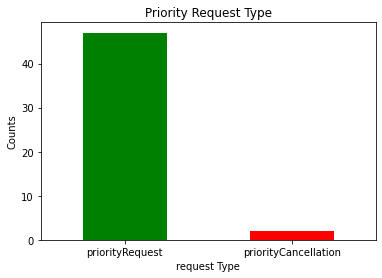

In [55]:
_ = srm_df['PriorityRequestType'].value_counts().plot.bar(color=['g', 'r'])
plt.xlabel('request Type')
plt.xticks(rotation=360, horizontalalignment="center")
plt.ylabel('Counts')
plt.title('Priority Request Type')

Text(0.5, 1.0, 'SRM_Data')

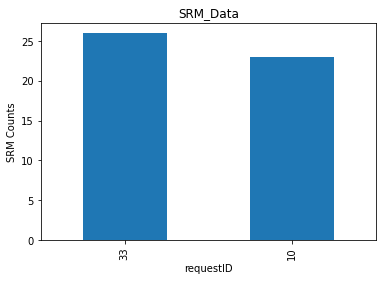

In [56]:
# Plot Data by different requestIDs
_ = srm_raw['RequestID'].value_counts().plot.bar()
plt.xlabel('requestID')
plt.ylabel('SRM Counts')
plt.title('SRM_Data')

In [57]:
# Request ID by timing
srm_fig = px.scatter(srm_raw, x='ode_timeStamp', y='MsgCount', color='RequestID',
                     hover_name='RequestID',  hover_data=['Heading', 'PriorityRequestType', 'LaneID'],
                     title='SRM timing',
                     width=800, height=400)
srm_fig.show()

**Note**: left (blue) is heading North with reqID 10 and right (yellow) req id 33 heading South

In [58]:
#Define the bounding box 
Bbox_srm = ((srm_raw.Lon.min(), srm_raw.Lon.max(),      
         srm_raw.Lat.min(), srm_raw.Lat.max()))
Bbox_srm

(-105.0914793, -105.0912196, 39.6064132, 39.6137158)

**Example**
1. A transit vehicle enters DSRC range and approaches signalized intersections
2. The transit vehicle wirelessly broadcasts a SRM, with its ETA and the identifier of the lanes to enter and egress at both intersections
3. The RSU for at an intersection receives the SRM and relays the request to the TSC, which processes the request.

In [59]:
srm_raw_fig = px.scatter_mapbox(srm_raw, lat="Lat", lon="Lon", zoom=12, color='RequestID',
                            hover_data = ['ode_timeStamp', 'RequestID', 'Heading', 'PriorityRequestType', 'LaneID', 'IntersectionID'],
                            center=dict(lon=Bbox_srm[0], lat=Bbox_srm[3]),
                            width=450*1.5, height=450*1.5,
                            mapbox_style='dark') #'open-street-map')
srm_raw_fig.show()

___________
# 4. SSM: Signal Status Message

- **SAE Standards for SSM**: connected intersection (CI) Surface Vehicle Standard: https://www.sae.org/standards/content/j2735_202007/
    * Message: MSG_SignalRequestMessage (SRM)
        - **Use:** The signal status message is a message sent by an RSU in a signalized intersection. It is used to relate the currentcstatus of the signal and the collection of pending or active preemption or priority requests acknowledged by the controller.cIt is also used to send information about preemption or priority requests which were denied. This in turn allows a dialogcacknowledgment mechanism between any requester and the signal controller. The data contained in this message allowscother users to determine their “ranking” for any request they have made as well as to see the currently active events. Whencthere have been no recently received requests for service messages, this message may not be sent. While the outcome of all pending requests to a signal can be found in the signal status message, the current active event (if any) will be reflected in the SPAT message contents. 


### 4.1. Query SAE Standards for SSM

- REQUIRED vs OPTIONAL: SAE_J2735_202007

***SignalStatusMessage: Schema***

SSM DataFrames | DataFrame Name | Representation |  Description |
:-------------:|:--------------:|:-----------:|:--------------:|
srm - metadata | originIP - rsuIP | User Implementation | Roadside Unit Device |
srm - metadata | odeReceivedAt - ode_timeStamp | User Implementation | CDOT Connected Vehilce Operational Data Environment | 
timeStamp | MinuteOfTheYear | OPTIONAL |  The Estimated Time of Arrival (ETA) when the service is requested - replaced with ode_timeStamp |
second | DSecond | STANDARD |  The Estimated Time of Arrival (ETA) when the service is requested -  replaced with ode_timeStamp |
sequenceNumber | MsgCount| OPTIONAL | Sequence number within a stream of messages with the same DSRCmsgID and from the same sender | 
status | SignalStatusList | STANDARD | |

***SignalStatusList: DF status***
- Use: The DF_SignalStatus data frame is used to provide the status of a single intersection to others, including any active preemption or priority state in effect. 

SignalStatus | Feature Name | Representation | Description |
:------:|:------------:|:--------------:|:-----------:|
squenceNumber | MsgCount | STANDARD | changed whenever the below contents have change |
id | IntersectionReferenceID | STANDARD | this provides a unique mapping to the intersection map in question which provides complete location and approach/movement/lane data as well as zones for priority/preemption |
id - IntersectionReferenceID | region - RoadRegulatorID | OPTIONAL | a globally unique regional assignment value typical assigned to a regional DOT authority the value zero shall be used for testing needs|
id - IntersectionReferenceID | id - IntersectionrID | STANDARD | a unique mapping to the intersection in question within the above region of use | 
sigStatus | SignalStatusPackageList | STANDARD |  a list of detailed status containing all priority or preemption state data, both active and pending, and who requested it requests which are denied are also listed here for a short period of time |

***sigStatus: DF SignalStatusPackage (sigStatus)***
- Use: Use: The DF_SignalStatusPackage data frame contains all the data needed to describe the preemption or priority state of the signal controller with respect to a given request and to uniquely identify the party who requested that state to occur. It should be noted that this data frame describes both active and anticipated states of the controller. A requested service may not be active when the message is created and issued. A requested service may be rejected. This structure allows the description of pending requests that have been granted (accepted rather than rejected) but are not yet active and being serviced. It also provides for the description of rejected requests so that the initial message is acknowledged (completing adialog using the broadcast messages)

SignalStatusPackage  | Feature Name | Representation | Description |
:------:|:------------:|:--------------:|:-----------:|
requester | SignalRequesterInfo | OPTIONAL | The party that made the initial SRM request |
inboundOn | IntersctionAccessPoint | STANDARD |  estimated lane/approach of vehicle |
outboundOn | IntersectionAccessPoint | OPTIONAL | - |
status | PrioritizationResponseStatus | STANDARD| SRM status of request, this may include rejection |

_______________________ 

##### SQL Query Notes

RSU - IntersectionID |   Date          |  SRM_counts       | SRM Time Range | SRM duration |
:---:|:----------------:|:------------- -:|:--------------:|:------------:|
11.11.81.22 - Bowles Ave #12107 | 27 October 2022 | 205 | 2022-10-27 12:52:59.856139 to 2022-10-27 13:06:16.383096 | 00:13:16.526957|

In [60]:
# Load Data
ssm_raw = pd.read_csv('raw_ssm_df.csv')
ssm_raw.head()

,rsuIP,ode_timeStamp,sequenceNumber,MsgCount,RoadRegulatorID,IntersectionID,TemporaryID,entityID,RequestID,LaneID,ApproachID,LaneConnectionID,status
0,10.11.81.22,2022-10-27 12:51:39.294872,NaN,0,NaN,12110,NaN,1780166822,7,9,NaN,NaN,granted
1,10.11.81.22,2022-10-27 12:51:40.323809,NaN,0,NaN,12110,NaN,1780166822,7,9,NaN,NaN,granted
2,10.11.81.22,2022-10-27 12:51:41.299232,NaN,0,NaN,12110,NaN,1780166822,7,9,NaN,NaN,granted
3,10.11.81.22,2022-10-27 12:51:42.309040,NaN,0,NaN,12110,NaN,1780166822,7,9,NaN,NaN,granted
4,10.11.81.22,2022-10-27 12:51:43.306710,NaN,0,NaN,12110,NaN,1780166822,7,9,NaN,NaN,granted


### RoadSide Unit [RSU] ➡ SSM
- This device provides the status of each priority request (SRM received by one or more signalized intersections)
- Broadcast by the infrastructure (Roadside Unit) and can be received by a vehicle On-Board Unit [OBU]

### 4.2 SSM Data Wrangling/Cleaning

In [61]:
ssm_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rsuIP             294 non-null    object 
 1   ode_timeStamp     294 non-null    object 
 2   sequenceNumber    0 non-null      float64
 3   MsgCount          294 non-null    int64  
 4   RoadRegulatorID   0 non-null      float64
 5   IntersectionID    294 non-null    int64  
 6   TemporaryID       0 non-null      float64
 7   entityID          294 non-null    int64  
 8   RequestID         294 non-null    int64  
 9   LaneID            294 non-null    int64  
 10  ApproachID        0 non-null      float64
 11  LaneConnectionID  0 non-null      float64
 12  status            294 non-null    object 
dtypes: float64(5), int64(5), object(3)
memory usage: 30.0+ KB


In [62]:
# Unique values in each column
ssm_raw.nunique().sort_values(ascending=True)

sequenceNumber        0
RoadRegulatorID       0
TemporaryID           0
ApproachID            0
LaneConnectionID      0
rsuIP                 1
MsgCount              1
entityID              1
status                1
IntersectionID        6
LaneID                9
RequestID            12
ode_timeStamp       294
dtype: int64

**NOTE**: Missing Data in numerous columns of Signal Status Messages
- no tempID to identify vehicle
- no inboundOn approach, connection missing similar to SRM

In [63]:
# Select specific intersection ID
ssm_raw = ssm_raw.loc[ssm_raw['IntersectionID'] == 12107]

In [64]:
# Keep columns by index
print('SSM dataframe:')
ssm_df = ssm_raw.iloc[:, [1, 3, 5, 6, 7, 8, 9, 12]]
ssm_df.head()

SSM dataframe:


,ode_timeStamp,MsgCount,IntersectionID,TemporaryID,entityID,RequestID,LaneID,status
66,2022-10-27 12:52:57.279283,0,12107,NaN,1780166822,10,2,granted
67,2022-10-27 12:52:58.284391,0,12107,NaN,1780166822,10,2,granted
68,2022-10-27 12:52:59.282458,0,12107,NaN,1780166822,10,2,granted
69,2022-10-27 12:53:00.282682,0,12107,NaN,1780166822,10,2,granted
70,2022-10-27 12:53:01.280900,0,12107,NaN,1780166822,10,2,granted


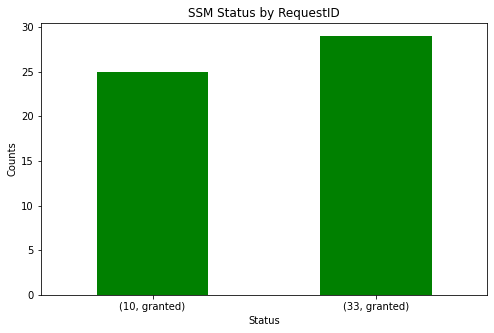

In [65]:
ssm_status = ssm_df.groupby(['RequestID'])['status'].value_counts()
_ = ssm_status.plot.bar( title='SSM Status by RequestID',
               ylabel='Counts', xlabel='Status', rot=0, color='g', figsize=(8, 5))

### SSM ➡ [OBU] Priority Status
##### Example
1. A RSU receives a SRM requests and the TSC processes the request
2. The signal controller provides the TSC with the status of the requests, 
    * then the TSC generates a SSM that is broadcasted by the RSU with the status of all SRM requests received.
3. Transit vehicles receive the SSM and travel through the signalized intersection when service is provided.
__________

# 5. BSM: Basic Saftey Message

### BSM Standards
- **Use:** The basic safety message (BSM) is used in a variety of applications to exchange safety data regarding vehicle state. 
    This message is broadcast frequently to surrounding vehicles with data content as required by safety and other applications. 
    Transmission rates are beyond the scope of this standard, but a rate 10 times per second is typical when congestion control 
    algorithms do not prescribe a reduced rate. Part I data shall be included in every BSM. Part II data items are optional for a
    given BSM and are included as needed according to policies that are beyond the scope of this standard. A BSM without 
    Part II optional content is a valid message. 
    
## 5.1 Query SAE Standards for BSM
***BSMcoreData (BSM Part One): STANDARD**

Name | Feature Name | Description | 
:------:|:------------:|:-----:|
msgCnt | MsgCount | provide a sequence number within a stream of messages with the same DSRCmsgID and from the same sender | 
id | TemporaryID | identify the local vehicles that are interacting during an encounter |
secMark | DSecond | integer values from zero to 60999, representing the milliseconds within a minute |
lat | Latitude | LSB = 1/10 microdegree. Providing a range of plus-minus 90 degrees |
long | Longitude | LSB = 1/10 microdegree. Providing a range of plus-minus 180 degrees |
elev | Elevation | units of 10 cm steps above or below the reference ellipsoid. Providing a range of -409.5 to + 6143.9 meters. The value -4096 shall be used when Unknown is to be sent |
accuracy | PostionalAccuracy | model the accuracy of the positional determination with respect to each given axis |
transmission | TranismissionState | gears |
speed | Speed | Units of 0.02 m/s. The value 8191 indicates that speed is unavailable |
heading | Heading | LSB of 0.0125 degrees. A range of 0 to 359.9875 degrees |
angle | SteeringWheelAngle | 
accelSet | AccelerationSet4Way |
brakes | BrakeSystemStatus | structure consist of a sequence of items which provide status flags for any active brakes per wheel, the traction control system, the anti-lock brake system, the stability control system, the brake boost system, and the auxiliary brake system | 
size | VehicleSize |

___________
##### SQL Query Notes

RSU - IntersectionID |   Date          |  SRM_counts       | SRM Time Range | SRM duration |
:---:|:----------------:|:------------- -:|:--------------:|:------------:|
11.11.81.22 - Bowles Ave #12107 | 27 October 2022 | 205 | 2022-10-27 12:52:59.856139 to 2022-10-27 13:06:16.383096 | 00:13:16.526957|


In [66]:
# Load Data
bsm_raw = pd.read_csv('raw_bsm_df.csv')
bsm_raw.head()

,rsuIP,ode_timeStamp,Msgcount,TemporaryID,DSecond,Lat,Lon,Elevation,Speed,Heading
0,10.11.81.22,2022-10-27 12:52:00.108899,34,786BDA84,16,39.595213,-105.091279,1679.4,21.34,0.3
1,10.11.81.22,2022-10-27 12:52:00.189447,35,786BDA84,16,39.595213,-105.091279,1679.4,21.34,0.3
2,10.11.81.22,2022-10-27 12:52:00.289257,36,786BDA84,118,39.595233,-105.091279,1679.5,21.32,0.2
3,10.11.81.22,2022-10-27 12:52:00.383746,37,786BDA84,216,39.595252,-105.091279,1679.5,21.38,359.9
4,10.11.81.22,2022-10-27 12:52:00.489339,38,786BDA84,317,39.595271,-105.091279,1679.6,21.38,0.3


In [67]:
bsm_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3353 entries, 0 to 3352
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rsuIP          3353 non-null   object 
 1   ode_timeStamp  3353 non-null   object 
 2   Msgcount       3353 non-null   int64  
 3   TemporaryID    3353 non-null   object 
 4   DSecond        3353 non-null   int64  
 5   Lat            3353 non-null   float64
 6   Lon            3353 non-null   float64
 7   Elevation      3353 non-null   float64
 8   Speed          3353 non-null   float64
 9   Heading        3353 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 262.1+ KB


In [68]:
print('Dataframe matrix:', bsm_raw.shape, '\n')

print('Number of unique vehicles interacting during an encounter:', bsm_raw.TemporaryID.nunique())

bsm_raw['ode_timeStamp'] = pd.to_datetime(bsm_raw['ode_timeStamp'])
bsm_startTime = bsm_raw['ode_timeStamp'].iloc[0]
bsm_endTime = bsm_raw['ode_timeStamp'].iloc[-1] 

print('\nBSM Time Range:\n', bsm_raw['ode_timeStamp'].iloc[0], '\n', bsm_raw['ode_timeStamp'].iloc[-1])
print('\nDuration of BSMs:', bsm_raw['ode_timeStamp'].iloc[-1] - bsm_raw['ode_timeStamp'].iloc[0])

Dataframe matrix: (3353, 10) 

Number of unique vehicles interacting during an encounter: 4

BSM Time Range:
 2022-10-27 12:52:00.108899 
 2022-10-27 13:06:59.934563

Duration of BSMs: 0 days 00:14:59.825664


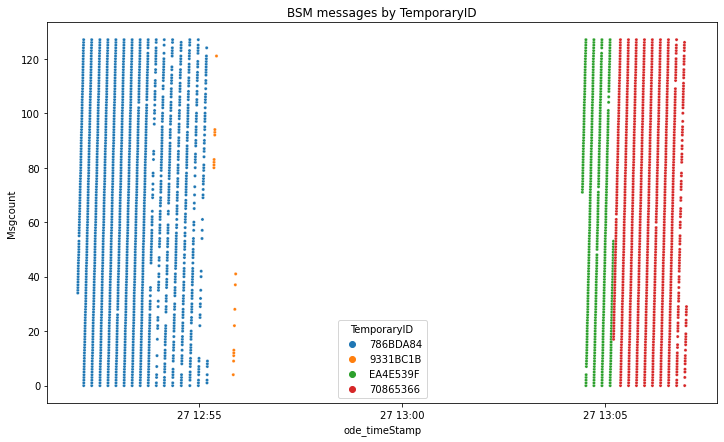

In [69]:
plt.figure(figsize=(12,7))
ax = sns.scatterplot(data=bsm_raw, x='ode_timeStamp', y='Msgcount', hue='TemporaryID', s=10)
plt.title('BSM messages by TemporaryID')
plt.show()

In [70]:
# Select specific intersection ID
bsm_df = bsm_raw.loc[bsm_raw['TemporaryID'].isin(['786BDA84', '70865366'])]

In [71]:
#Define the bounding box 
Bbox = ((bsm_df.Lon.min(), bsm_df.Lon.max(),      
         bsm_df.Lat.min(), bsm_df.Lat.max()))
Bbox

(-105.0915156, -105.091135, 39.595213, 39.6194884)

In [72]:
fig1 = px.scatter_mapbox(bsm_df, lat="Lat", lon="Lon", zoom=12, color='TemporaryID',
                         center=dict(lon=Bbox[0], lat=Bbox[3]),
                         width=500*1.5, height=500*1.5,
                         title='BSM Geolocation',
                         mapbox_style='dark')
fig1.show()

# 6. Results
### 6.1 Data Integration

In [73]:
srm_df.head()

,ode_timeStamp,MsgCount,IntersectionID,RequestID,PriorityRequestType,LaneID,TemporaryID,StationID,Lat,Lon,Heading,Velocity
53,2022-10-27 12:52:59.856139,34,12107,10,priorityRequest,2,NaN,1780166822,39.606413,-105.091237,0.2,19.68
54,2022-10-27 12:53:00.856654,35,12107,10,priorityRequest,2,NaN,1780166822,39.606591,-105.091236,0.2,19.74
55,2022-10-27 12:53:01.852736,36,12107,10,priorityRequest,2,NaN,1780166822,39.606751,-105.091235,0.4,19.74
56,2022-10-27 12:53:02.855813,37,12107,10,priorityRequest,2,NaN,1780166822,39.606928,-105.091235,359.9,19.66
57,2022-10-27 12:53:03.858064,38,12107,10,priorityRequest,2,NaN,1780166822,39.607123,-105.091235,0.2,19.52


In [74]:
ssm_df.head()

,ode_timeStamp,MsgCount,IntersectionID,TemporaryID,entityID,RequestID,LaneID,status
66,2022-10-27 12:52:57.279283,0,12107,NaN,1780166822,10,2,granted
67,2022-10-27 12:52:58.284391,0,12107,NaN,1780166822,10,2,granted
68,2022-10-27 12:52:59.282458,0,12107,NaN,1780166822,10,2,granted
69,2022-10-27 12:53:00.282682,0,12107,NaN,1780166822,10,2,granted
70,2022-10-27 12:53:01.280900,0,12107,NaN,1780166822,10,2,granted


In [75]:
bsm_df.head()

,rsuIP,ode_timeStamp,Msgcount,TemporaryID,DSecond,Lat,Lon,Elevation,Speed,Heading
0,10.11.81.22,2022-10-27 12:52:00.108899,34,786BDA84,16,39.595213,-105.091279,1679.4,21.34,0.3
1,10.11.81.22,2022-10-27 12:52:00.189447,35,786BDA84,16,39.595213,-105.091279,1679.4,21.34,0.3
2,10.11.81.22,2022-10-27 12:52:00.289257,36,786BDA84,118,39.595233,-105.091279,1679.5,21.32,0.2
3,10.11.81.22,2022-10-27 12:52:00.383746,37,786BDA84,216,39.595252,-105.091279,1679.5,21.38,359.9
4,10.11.81.22,2022-10-27 12:52:00.489339,38,786BDA84,317,39.595271,-105.091279,1679.6,21.38,0.3


### 6.2 Data Model

In [76]:
srm_raw_fig = px.scatter_mapbox(srm_raw, lat="Lat", lon="Lon", zoom=12, color='RequestID',
                            hover_data = ['ode_timeStamp', 'RequestID', 'Heading', 'PriorityRequestType', 'LaneID', 'IntersectionID'],
                            center=dict(lon=Bbox_srm[0], lat=Bbox_srm[3]),
                            width=450*1.5, height=450*1.5,
                            title='SRM output',
                            mapbox_style='dark') #'open-street-map')
srm_raw_fig.show()

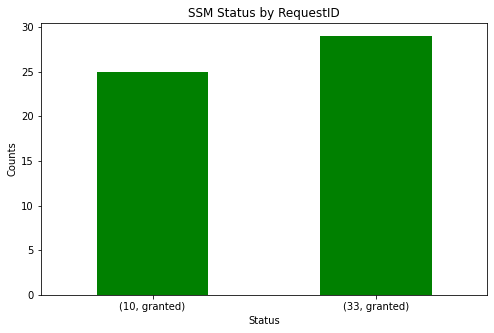

In [77]:
ssm_status = ssm_df.groupby(['RequestID'])['status'].value_counts()
_ = ssm_status.plot.bar( title='SSM Status by RequestID',
               ylabel='Counts', xlabel='Status', rot=0, color='g', figsize=(8, 5))

In [78]:
fig1 = px.scatter_mapbox(bsm_df, lat="Lat", lon="Lon", zoom=12, color='TemporaryID',
                         center=dict(lon=Bbox[0], lat=Bbox[3]),
                         width=500*1.5, height=500*1.5,
                         title='BSM output',
                         mapbox_style='dark')
fig1.show()